In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers,callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
np.random.seed(0)

Loading dataset

In [2]:
df=pd.read_csv('WeatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

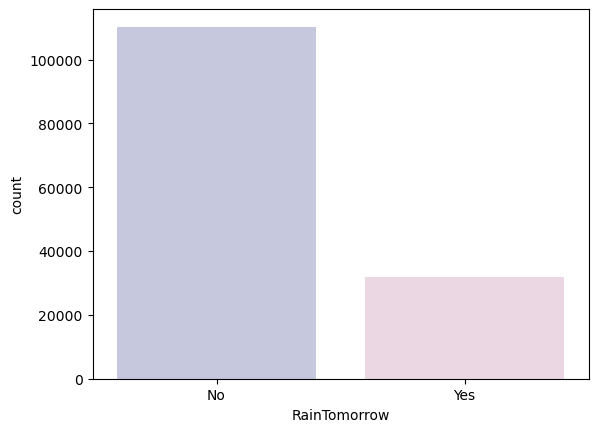

In [5]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= df["RainTomorrow"], palette= cols)

<AxesSubplot:>

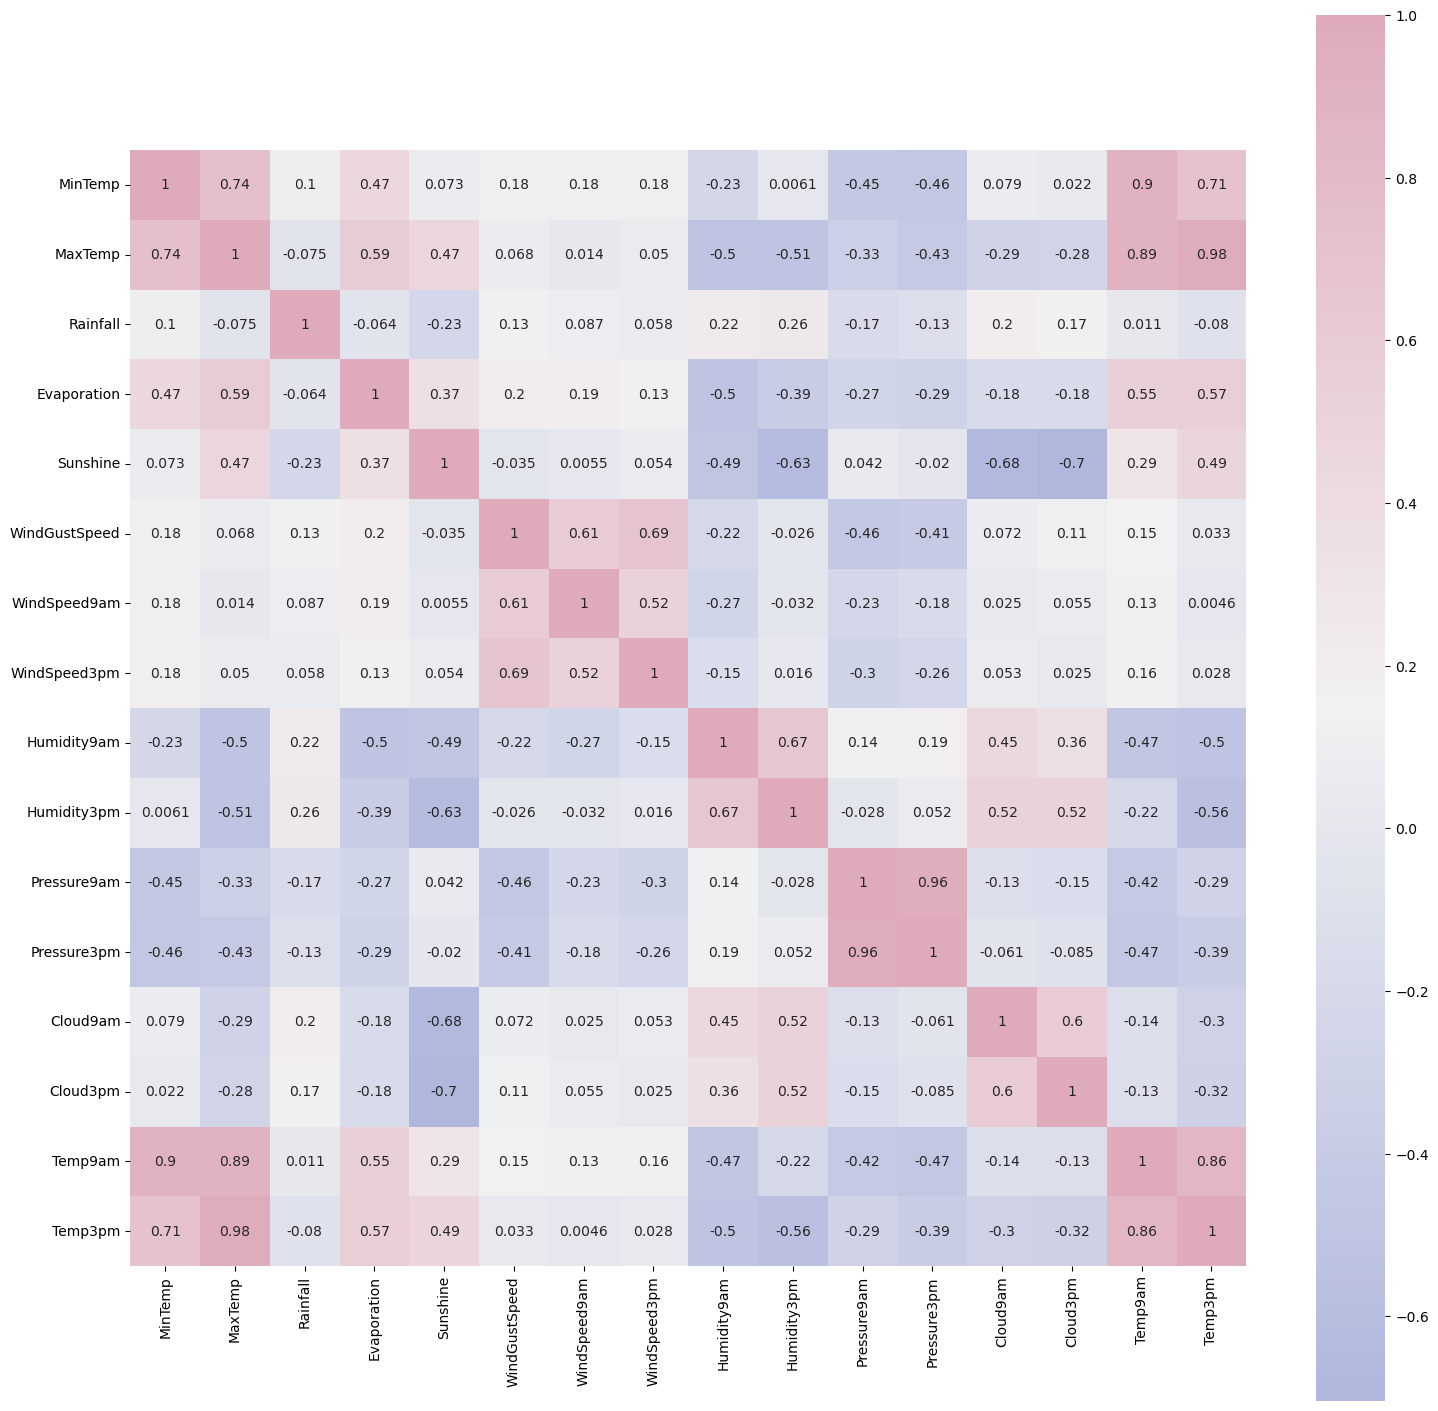

In [6]:
#correlation among numeric attributes
corrmat=df.corr()
cmap=sns.diverging_palette(260,-10,s=50,l=75,n=6,as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap=cmap,annot=True,square=True)

In [7]:
#parse date into datetime
leng=df['Date'].str.len()
leng.value_counts()

10    145460
Name: Date, dtype: int64

In [8]:
#There don't seem to be any error in dates so parsing values into datetime
df['Date']=pd.to_datetime(df['Date'])
#creating column for year
df['Year']=df.Date.dt.year

#fn to encode datetime into cyclic parameters
def encode(data,col,max_val):
    data[col+'_sin']=np.sin(2*np.pi+data[col]/max_val)
    data[col+'_cos']=np.cos(2*np.pi+data[col]/max_val)
    return data
df['Month']=df.Date.dt.month
df=encode(df,'Month',12)

df['Day']=df.Date.dt.day
df=encode(df,'Day',31)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,Year,Month,Month_sin,Month_cos,Day,Day_sin,Day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,0.841471,0.540302,1,0.032252,0.999480
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,0.841471,0.540302,2,0.064471,0.997920
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,0.841471,0.540302,3,0.096623,0.995321
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,0.841471,0.540302,4,0.128675,0.991687
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,0.841471,0.540302,5,0.160592,0.987021


Text(0.5, 0, 'Days in Year')

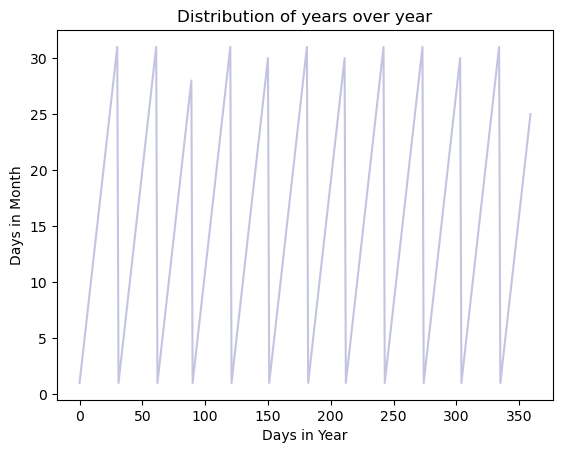

In [10]:
# roughly a year's span section 
section=df[:360]
tm=section['Day'].plot(color='#C2C4E2')
tm.set_title("Distribution of years over year")
tm.set_ylabel('Days in Month')
tm.set_xlabel('Days in Year')

Text(0.5, 0, 'Sine Encoded Months')

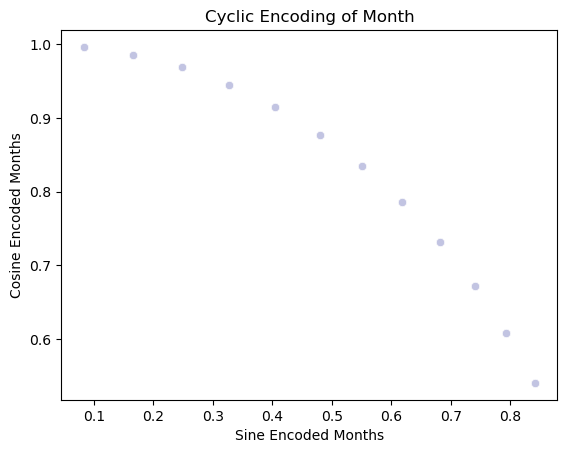

In [12]:
cyclic_month = sns.scatterplot(x="Month_sin",y="Month_cos",data=df, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

In [14]:
# Get list of categorical variables
s = (df.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [15]:
# Missing values in categorical variables
for i in object_cols:
    print(i, df[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [17]:
# Filling missing values with mode of the column in value

for i in object_cols:
    df[i].fillna(df[i].mode()[0], inplace=True)

In [19]:
# Get list of neumeric variables
t = (df.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']


In [20]:
# Missing values in numeric variables
for i in num_cols:
    print(i, df[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
Month_sin 0
Month_cos 0
Day_sin 0
Day_cos 0


In [23]:
# Filling missing values with median of the column in value
for i in num_cols:
    df[i].fillna(df[i].median(), inplace=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

**Data Preprocessing**

In [25]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    df[i] = label_encoder.fit_transform(df[i])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [29]:
features = df.drop(['RainTomorrow', 'Date','Day', 'Month'], axis=1) # dropping target and extra columns
target = df['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,-5.633017e-14,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.243854e-15,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,6.513740e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,9.152711e-15,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,1.352327e-14,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-4.338304e-15,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,1.864381e-14,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,-1.167921e-14,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,-7.433272e-15,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,1.791486e-15,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


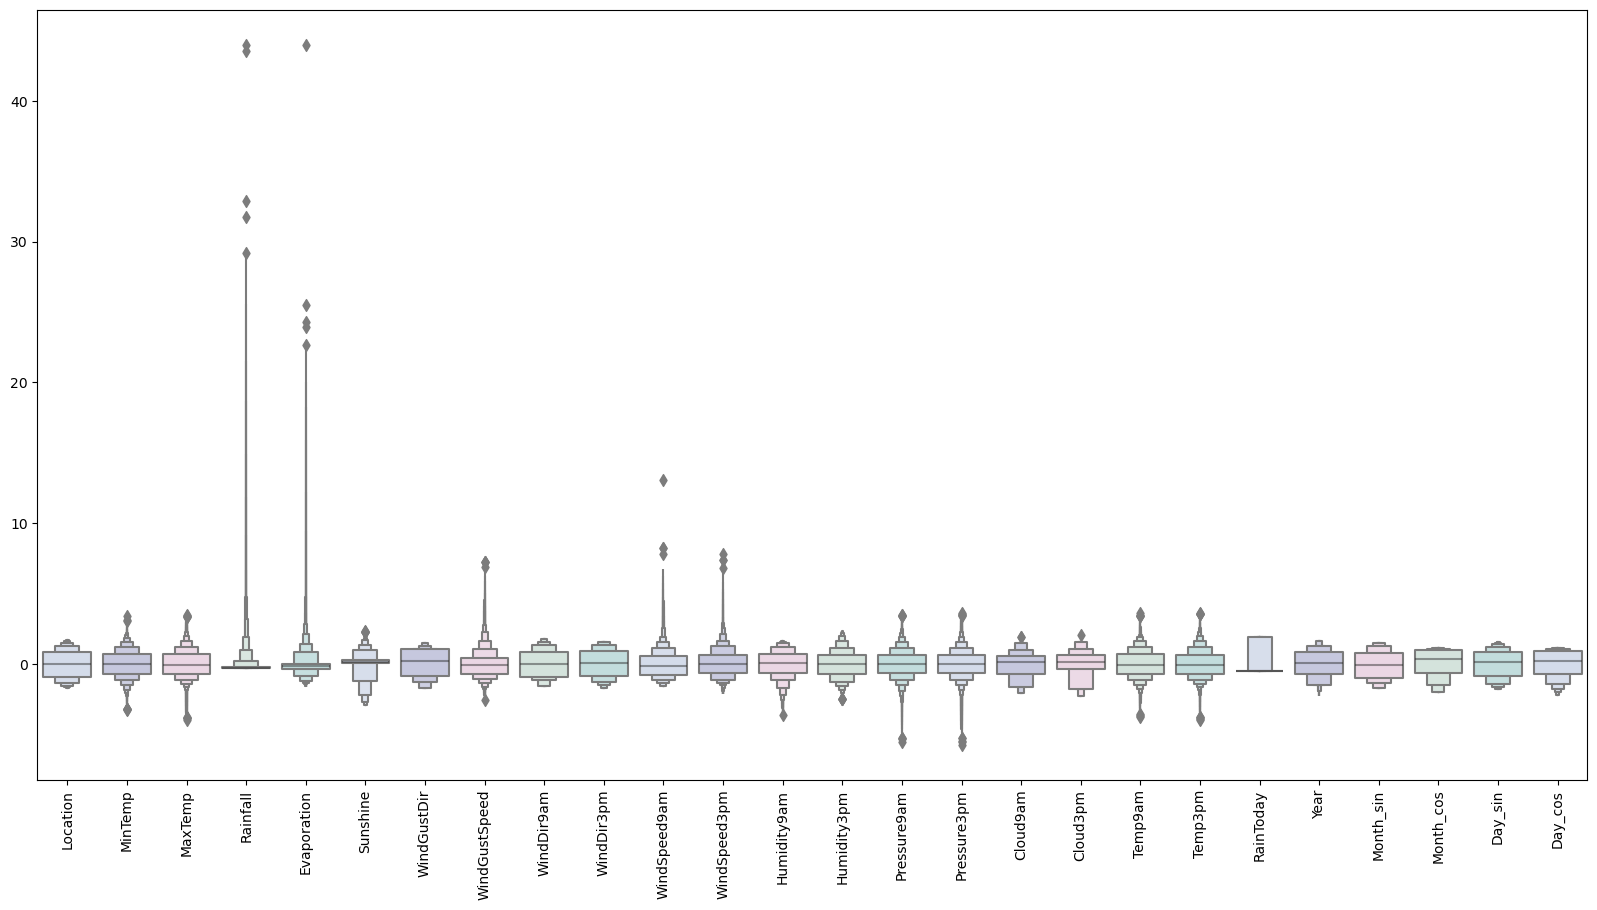

In [30]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [31]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

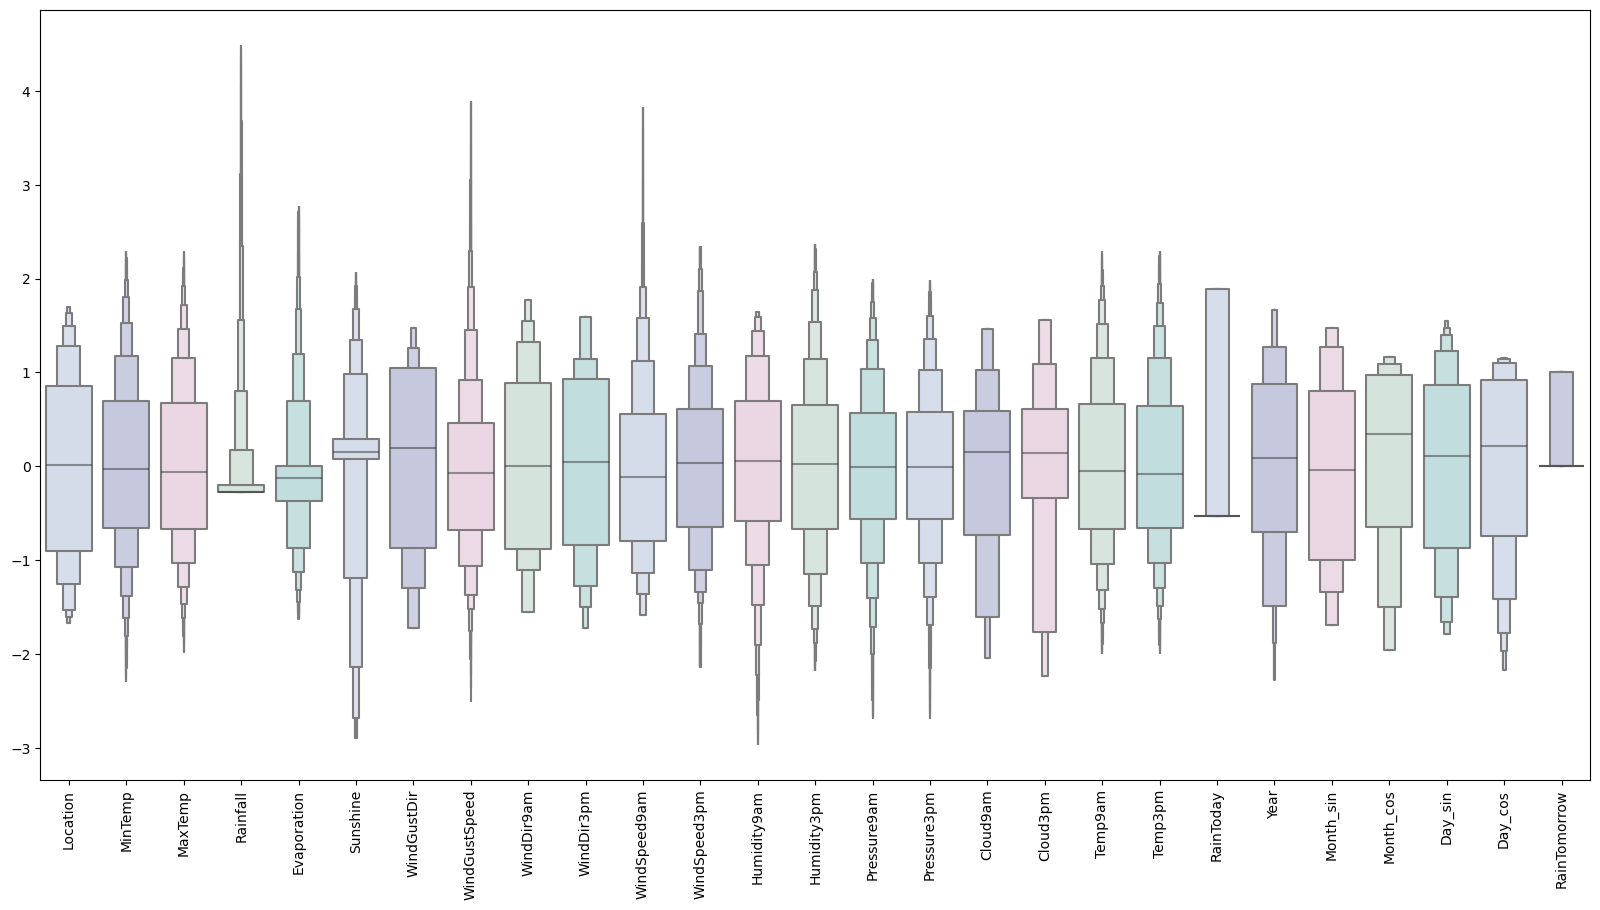

In [32]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [33]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 26)

In [34]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2551/2551 [==============================] - 2s 737us/step - loss: 0.4908 - accuracy: 0.7863 - val_loss: 0.3923 - val_accuracy: 0.7926
Epoch 2/150
2551/2551 [==============================] - 2s 677us/step - loss: 0.4222 - accuracy: 0.8263 - val_loss: 0.3774 - val_accuracy: 0.8385
Epoch 3/150
2551/2551 [==============================] - 2s 691us/step - loss: 0.4116 - accuracy: 0.8377 - val_loss: 0.3700 - val_accuracy: 0.8419
Epoch 4/150
2551/2551 [==============================] - 2s 674us/step - loss: 0.4049 - accuracy: 0.8396 - val_loss: 0.3665 - val_accuracy: 0.8426
Epoch 5/150
2551/2551 [==============================] - 2s 699us/step - loss: 0.4018 - accuracy: 0.8389 - val_loss: 0.3645 - val_accuracy: 0.8428
Epoch 6/150
2551/2551 [==============================] - 2s 675us/step - loss: 0.3982 - accuracy: 0.8399 - val_loss: 0.3639 - val_accuracy: 0.8442
Epoch 7/150
2551/2551 [==============================] - 2s 664us/step - loss: 0.3967 - accuracy: 0.8399 - val_loss: 0

2551/2551 [==============================] - 2s 639us/step - loss: 0.3741 - accuracy: 0.8375 - val_loss: 0.3536 - val_accuracy: 0.8443
Epoch 57/150
2551/2551 [==============================] - 2s 638us/step - loss: 0.3733 - accuracy: 0.8378 - val_loss: 0.3535 - val_accuracy: 0.8437
Epoch 58/150
2551/2551 [==============================] - 2s 654us/step - loss: 0.3729 - accuracy: 0.8373 - val_loss: 0.3531 - val_accuracy: 0.8443


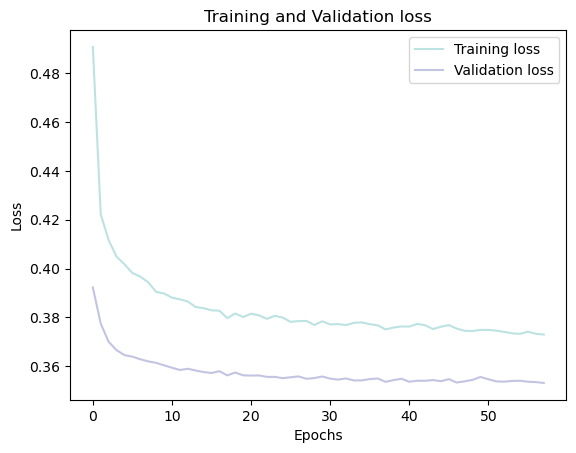

In [35]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

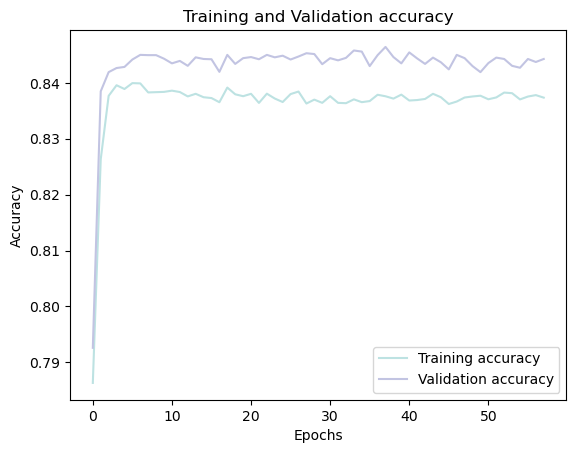

In [36]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

<AxesSubplot:>

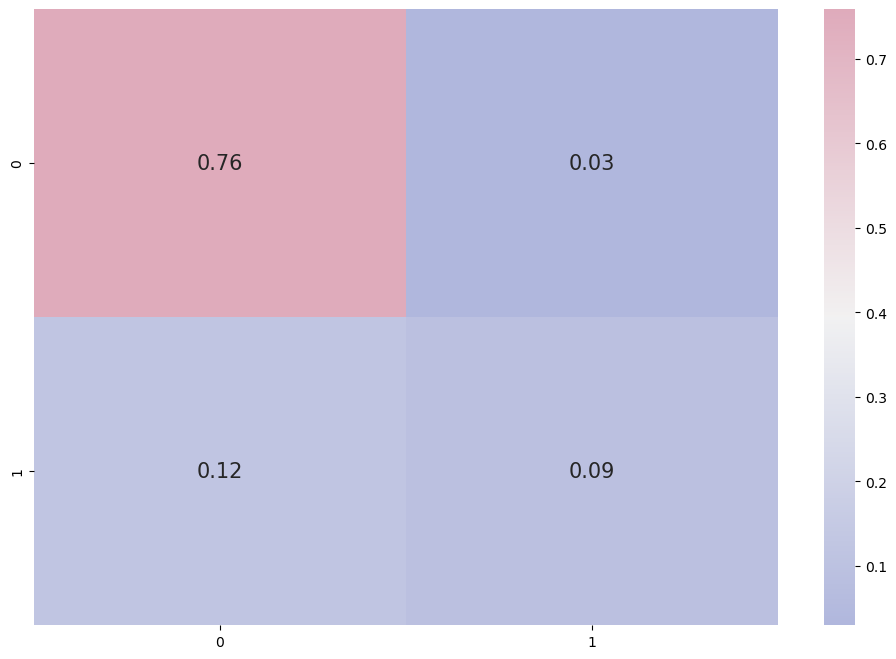

In [38]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     20110
           1       0.75      0.43      0.54      5398

    accuracy                           0.85     25508
   macro avg       0.81      0.69      0.73     25508
weighted avg       0.84      0.85      0.83     25508

